In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import os
from os import path 
from time import time
import random
import json

In [2]:
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "TRAS.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

import django
django.setup()

from django.core.exceptions import ObjectDoesNotExist
from django.db import transaction
from django.conf import settings
from django_pandas.io import read_frame

from asgiref.sync import sync_to_async

from proto.models import Attraction, Review

In [3]:
from nltk.tokenize import RegexpTokenizer
from nltk import tokenize 
from nltk import Text
from nltk.corpus import stopwords

import nltk

In [75]:
from gensim.summarization.summarizer import summarize

In [4]:
retokenize = RegexpTokenizer("[\w]+")

In [5]:
attr_qs = Attraction.objects.all()
review_qs = Review.objects.all()

In [7]:
#Attractions_df = read_frame(attr_qs)
#All_reviews_df = read_frame(review_qs)
#Attractions_df.to_csv("Attractions.csv")
#Attractions_df.to_csv('All_reviews.csv')

In [8]:
Attractions_df = read_csv("Attractions.csv")
All_reviews_df = read_csv('All_reviews.csv')

In [98]:
text = " ".join([text for text in All_reviews_df[All_reviews_df['attraction'] == 'Deoksugung']['text']])


['Located near the City Hall Metro station, this Palace complex houses a very well maintained garden, the National Art Museum influenced by the Western Architecture along with other traditional structures',
 'The changing of guard ceremony is also held in this palace which is another major attraction for visitors',
 'The Palace ground is huge where the palaces of each dynasty are spread over the whole area with the rock walls',
 'interesting history of the palace and also the nice change-of-guards ceremony at the main gate',
 'Good place to visit if one goes for a walking tour with City Hall, Arts Museum, Presidential Palace, the Stream and Insadong',
 'This palace and the surrounding grounds are much smaller than the nearby Gyeongbokgung Palace but it is still worth a visit if you have an hour or so to spare',
 'We arrived just as the changing of the guard ceremony was starting (11am) which takes place just in front of the main gate',
 'Deoksugung palace is very interesting palace for

In [10]:
stop_words = set(stopwords.words('english')) 
stop_words = stop_words|set(['.', ',', 'the', "'s"])

In [12]:
lower_text =''.join(All_reviews_df['text']).lower()

pre_token = retokenize.tokenize(lower_text)
token = [a_token for a_token in pre_token if a_token not in stop_words]

text = Text(token)
fd = text.vocab()

dict_5000 = {word:i for (word, i) in zip(fd, range(len(fd))) if i < 5000}

In [14]:
def pre_process(Reviews_df):
    star_list = list(Reviews_df['star'])
    text_list = list(Reviews_df['text'])
    
    result_text = []
    for text in text_list:
        tokens = retokenize.tokenize(text)
        processed_list = []
        for token in tokens:
            if token in dict_5000:
                processed_list.append(dict_5000[token])
        result_text.append(processed_list)
    
    result_star = []
    for star in star_list:
        if star >4:
            result_star.append(1)
        else:
            result_star.append(0)
        
    X = np.array(result_text)
    Y = np.array(result_star)
    return X, Y

In [17]:
X_head, Y_head = pre_process(All_reviews_df[All_reviews_df['star'] != 4].head())
print(X_head)
Y_head

[list([599, 2, 290, 616, 1592, 228, 246, 512, 720, 37])
 list([3749, 476, 23, 47, 1122, 1507, 2475, 141, 88, 574, 178])
 list([4, 715, 327, 19, 61, 8, 4, 37, 3338, 932])
 list([6, 14, 179, 92, 92, 2476, 16, 715, 327, 14, 2881, 469, 239])
 list([869, 433, 2668, 595, 483, 115, 45, 31, 68, 3854, 12, 54, 755, 1095, 22, 1341, 1163, 273, 78, 470, 705, 16, 247, 345, 373, 16, 625, 95])]


array([1, 1, 1, 1, 1])

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

In [49]:
X, Y = pre_process(All_reviews_df[All_reviews_df['star'] != 4])

In [50]:
X_padded = pad_sequences(X, maxlen=100)

from numpy import savetxt
# define data
# save to csv file
savetxt('X.csv', X_padded, delimiter=',')
savetxt('Y.csv', Y, delimiter=',')

리뷰의 최대 길이 : 504
리뷰의 평균 길이 : 27.9826359715454


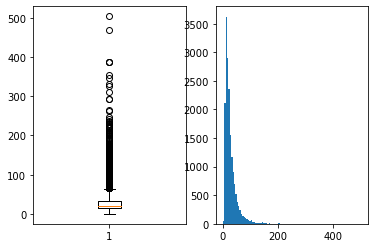

In [51]:
len_result = [len(s) for s in X]

print('리뷰의 최대 길이 : {}'.format(np.max(len_result)))
print('리뷰의 평균 길이 : {}'.format(np.mean(len_result)))

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=100)
plt.show()

In [43]:
from sklearn.model_selection import train_test_split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

In [53]:
max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [54]:
model = Sequential()

# 단어를 읽어오는 세포 5천개

model.add(Embedding(5000, 120))
# 단어 하나마다 세포가 하나씩
# 단어들을 120개로 임베딩딩
model.add(Dropout(0.2))
# LSTM
model.add(LSTM(120))
model.add(Dropout(0.2))
#DropOut으로 랜덤으로 노드를 꺼줌으로서, 과적합을 방지

# 은닉층...
model.add(Dense(1, activation='sigmoid'))

In [55]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [56]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64, callbacks=[es, mc])

Epoch 1/5
224/224 [==============================] - ETA: 0s - loss: 0.4657 - acc: 0.7921
Epoch 00001: val_acc improved from -inf to 0.82246, saving model to best_model.h5
224/224 [==============================] - 30s 133ms/step - loss: 0.4657 - acc: 0.7921 - val_loss: 0.4037 - val_acc: 0.8225
Epoch 2/5
224/224 [==============================] - ETA: 0s - loss: 0.3190 - acc: 0.8687
Epoch 00002: val_acc improved from 0.82246 to 0.83422, saving model to best_model.h5
224/224 [==============================] - 29s 128ms/step - loss: 0.3190 - acc: 0.8687 - val_loss: 0.3938 - val_acc: 0.8342
Epoch 3/5
224/224 [==============================] - ETA: 0s - loss: 0.2633 - acc: 0.8966
Epoch 00003: val_acc improved from 0.83422 to 0.83786, saving model to best_model.h5
224/224 [==============================] - 31s 138ms/step - loss: 0.2633 - acc: 0.8966 - val_loss: 0.4149 - val_acc: 0.8379
Epoch 4/5
224/224 [==============================] - ETA: 0s - loss: 0.2124 - acc: 0.9181
Epoch 00004: val

In [139]:
def top_low_n(name, n = 3):
    

    attraction_series = All_reviews_df[All_reviews_df['attraction']==name]['text'][::5]

    text = " ".join(attraction_series)
     
    sent_n = text.count(".")
    result = summarize(text, ratio = 200 / sent_n)

    sentence_list = [t.replace('\n','') for t in result.split(".") if t != '' ]
    
    result_sentences = []
    for sentence in sentence_list:
        tokens = retokenize.tokenize(sentence)
        processed_list = []
        for token in tokens:
            if token in dict_5000:
                processed_list.append(dict_5000[token])
        result_sentences.append(processed_list)


    X_sentence = np.array(result_sentences)
    X_sentence = pad_sequences(X_sentence, maxlen=max_len)

    prediction_list = model.predict(X_sentence)


    sent_predict_df = pd.DataFrame([(sentence, prediction) for sentence, prediction in zip(sentence_list, prediction_list)]).sort_values(by = 1)
    
    neg_sample = []
    pos_sample = []
    
    head = sent_predict_df.head(n)
    for star, sentence in zip(head[1], head[0]):
        if star < 0.1:
            neg_sample.append(sentence)
            print(star, "  :  ", sentence)
    
    tail = sent_predict_df.tail(n)
    for star, sentence in zip(tail[1], tail[0]):
        if star > 0.9:
            pos_sample.append(sentence)
            print(star, "  :  ", sentence)
    
    neg_sample = [item for item in neg_sample if len(item) < 200]
    
    pos_sample = [item for item in pos_sample if len(item) < 200]

    #Json string형태로 된 부정, 긍정 샘플을 반환
    
    return json.dumps({'neg':neg_sample, 'pos':pos_sample})

In [140]:
top_low_n('Gyeongbokgung Palace')

[0.0236662]   :   Please don't go to Gyeongbokgung Palace hoping or expecting to find an equal of the Forbidden City, but I think you will find something equally as interesting although rather less dramatic in scale
[0.06296527]   :   frankly i wasnt impressed much!If you skip it you wont miss much Huge and Massive
[0.9967663]   :   The gates and the palace are the stars but the dining hall on the pond is an incredible building in a beautiful setting
[0.99705815]   :   Don't forget to rent Hanbok (Korean traditional dress) It was my first encounter with this kind of architecture and I was thoroughly impressed
[0.9990595]   :   You can walk around the buildings at your own pace, and if you are wearing the national custom, entrance is free (you will see dressed up girls everywhere, another delight!)


'{"neg": ["Please don\'t go to Gyeongbokgung Palace hoping or expecting to find an equal of the Forbidden City, but I think you will find something equally as interesting although rather less dramatic in scale", "frankly i wasnt impressed much!If you skip it you wont miss much Huge and Massive"], "pos": ["The gates and the palace are the stars but the dining hall on the pond is an incredible building in a beautiful setting", "Don\'t forget to rent Hanbok (Korean traditional dress) It was my first encounter with this kind of architecture and I was thoroughly impressed", "You can walk around the buildings at your own pace, and if you are wearing the national custom, entrance is free (you will see dressed up girls everywhere, another delight!)"]}'

In [141]:
Attr_query = Attraction.objects.all()
update_list = []
for i, attraction in enumerate(Attr_query):
    print(attraction.name, "  start!")
    try:
        result = top_low_n(attraction.name, n = 5)
        attraction.review_sample = result
        update_list.append(attraction)
        print("End!")
    except Exception as e:
        print(e)
        continue

Gyeongbokgung Palace   start!
[0.0236662]   :   Please don't go to Gyeongbokgung Palace hoping or expecting to find an equal of the Forbidden City, but I think you will find something equally as interesting although rather less dramatic in scale
[0.06296527]   :   frankly i wasnt impressed much!If you skip it you wont miss much Huge and Massive
[0.9955851]   :   The setting between mountains and the city is amazing and the juxtaposition of the palace to modern Seoul is stunning
[0.99624383]   :   Guard changing ceremony (guards dressed in Korean traditional costumes) was a real pleasure to watch and gives you an opportunity to experience Korean tradition
[0.9967663]   :   The gates and the palace are the stars but the dining hall on the pond is an incredible building in a beautiful setting
[0.99705815]   :   Don't forget to rent Hanbok (Korean traditional dress) It was my first encounter with this kind of architecture and I was thoroughly impressed
[0.9990595]   :   You can walk around

[0.99043167]   :   You can download an app to add some augmented reality (AR) using the free wifi available
[0.9919028]   :   It’s 3D art and optical illusions at its finest!As an added bonus, the same ticket also gives you free access to Ice Museum and Carnival Street (all in the same building)
[0.99402463]   :   is a fun place to visit for everyone~ strongly recommend to download the camera apps to capture photo or video a wonderful few hours at this museum
[0.9942286]   :   Then we ended the visit by the Love Museum and that was just a whole bunch of laughter !!!The trick-eye paintings are just amazing and we really loved this part even more
[0.99564576]   :   I went to Trick Eye Museum with my boyfriend last weekend and we had SO much fun!We started by experiencing the new 3D option available through an app to enjoy even more the trick-eye paintings and it was super realistic and beyond our expectations!Then we visited the Ice Museum which was super interesting (we loved the iced s

[0.04707372]   :   I ended up arriving late and missing the first 10 minutes so I advise any tourists to leave yourself a lot of time in case you get lost like me!Once you finally do make it there though it’s worth it
[0.05024287]   :   A few words of basic English are used for instructions in the audience interactive parts, but the show is otherwise completely language independent
[0.9971268]   :   Outstanding showBeen there twice already, first back in 2013 with friends and now again this year with the family and it has never failed to be loved by everyone Would recommend everyone to attend this if you are in the area
[0.9979831]   :   A different kind of theater experience!A must do in seoul!!Very funny!!Great for kids too!!Small theater, you can sit anywhere and have a great view!A very funny show, you do not need Korean to understand, it is for everyone!The timing of the performers is spot on
[0.99821115]   :   The show is highly funny and the drums work is brilliant
[0.99925554] 

[0.05480951]   :   we saw on average about 10 motor bikes for food delivery in the 45 mins we were on the campus ground
[0.08011711]   :   One could walk around quite freely except for restricted areas
[0.09307972]   :   Worth the time if you are interested in a deep insight into Korea and it's history If you're fan of K-reality show so yes, otherwise, see know reason to visit, feel free to skip this spot & head straight to Hongik statio, where definitely more fun & happenings
[0.9825565]   :   I loveee being here (a shopaholic just like me) where i bought cloths, bags, cosmetic etc Surely we wanna come back here again ^-^ Near Eawha Womens University, there are so many interesting shops, which have what ladies needs, including fashion, accessories, shoes, + delicious foods
[0.9896525]   :   but along the way there is a lot of shops which cater to the university's students ( mainly young women)
[0.99047637]   :   Due the fact that our daughter is studying in that particular university 

[0.01852277]   :   The third gallery is the special events currently it's: Shooting the Elephant- this was my least favorite part of the museum- I wasn't a fan but the space itself was really cool!The third gallery is the special events currently it's: Shooting the Elephant- this was my least favorite part of the museum- I wasn't a fan but the space itself was really cool!I hope to go back and visit when a different special exhibit is going through
[0.05834502]   :   The exhibitions were rather boring in Museum 1 (you really have to like ceramics to enjoy it), but Museum 2 has some interesting modern art
[0.08814019]   :   I guess you could say that the surrounding area is quite pleasant; I felt much more positive and engaged while walking around than I've ever felt inside this 'museum'
[0.9958699]   :   The guide also has additional videos or photo books to look at the piece from a different view (like the back of it if you can't see it, or multiple pages of a book in a display case) 

[0.9530717]   :   It was a selfie heaven for all the girls so enjoying the actual art itself was a bit distracting with all the sounds of the cameras
[0.96471643]   :   Very interesting and wonderful
[0.99639976]   :   It was thoroughly enjoyable and well curated
[0.9975134]   :   Seeing that I was carrying a heavy bag, one of the staff shared about their free locker service which was very helpful
End!
Yongsan Family Park   start!
[0.05144954]   :   There's nothing much except the museum around, visitors aren't that many
[0.94663876]   :   We connected to the National Museum of Korean History and walked through the temple gardens then stopped for a drink near the top plaza and enjoyed the free outdoor concert
[0.95683646]   :   There's a nice playground for children too or lots of quiet space for those wanting to read a book, write or just enjoy quiet time
[0.9604619]   :   A great way to spend an hour each day either with lots of walking around amidst fresh air or keep trim with exerc

[0.9781371]   :   The whole exhibit of the museum is dedicated to the development of the Korean language
[0.9934156]   :   I must admit I was really surprised about how well everything was presented and the tour guide was really helpful
End!
Kwanghee Fasion Mall   start!
End!
Tourist Information Center of Korea Tourism Organization   start!
[0.03387415]   :   To be honest if you want to impress and attract tourists as the purpose of this centre, please hire staffs who can give good impression
[0.05894414]   :   The much needed brochures and maps are here
[0.9420139]   :   This place is created to serve, inform and entertain the tourists
[0.9456407]   :   if you wear hanbok and walk in the street, there are some foreign find you to take a photo with them, that was a good and unforgettable experience for me to experience the Korea culture, I strongly suggest if people want to try hanbok, I thought you can go there to experience and you will like it
[0.9573852]   :   This is good place to

[0.08386382]   :   I didn't really get the true meaning (I don't think that I'm the only one) so I looked it up
[0.9084046]   :   It's a busy bustling place by day I stayed at the Plaza hotel which is just across the road from the Seoul Plaza - a place apparently popular with protesters and demonstrators
[0.9087856]   :   It's a good landmark to meet friends or to use as a landmark to find your way around
[0.9178352]   :   Great service and added value for the business traveler
[0.92354596]   :   Police presence was always in the background - on one morning I saw quite a few police busses parked up in a side street presumably with occupants waiting to quell any trouble
[0.9808023]   :   Had the pleasure of staying at this hotel for three days and would definitely stay there again
End!
Ttukseom Hangang Park   start!
[0.9138002]   :   You get your own tube ring, go up the hill, sit on the tube and slide down the snow
[0.9180194]   :   But at least the snow tubing is already open
[0.93098

[0.90144986]   :   The women here very friendly and helpful telling us about all the popular sites (like Kakao Friends, Samsung store) around Gangnam Station, which is the most must-see place south of the Han River
[0.9623033]   :   The people were very helpful and friendly
[0.976835]   :   It is so amazing experience
[0.9960077]   :   What a random but totally enjoyable experience!The place was really nice, and the people are super helpful, and happy
End!
Paradise Casino Walkerhill   start!
[0.04857814]   :   I went last night with the intention of playing low buy-in blackjack, not only did I not get to play blackjack because there was an entire family of Chinese nationals who would call someone over to hold the seat when ever anyone left FOR HOURS, when I finally decided to play poker the other guests (again all Chinese nationals) were very rude and making cusses at me all night
[0.0772247]   :   Free food and drinks only for table games players, so if you want some free noodles, buy

[0.9962921]   :   Feel so goodI walk there at Thursday afternoon And no more touristOnly few local people I'm so glad can walk there I been at spring So different view from this two weather Suggest anyone should come here walk with your friend or bf/gfActually there was a big big parkSo different way at the different partIf want walk finish all the park way here ,thinking takes your time around 3hours , also you can rent at bike here , so nice biking here or running here ????????????????????????????????????????????????????????????????????You can rent the bike for riding, take a walk or jogging with the great Han River view!!Beautiful park with many locals exercising there
[0.9966099]   :   Rented a bicycle and took a long bicycle trail enjoying the amazing scenery of the river and flowers!An excellent place to enjoy the Cherry Blossom bloom
[0.9979738]   :   if you visit this place in the beginning to spring you will be able to see the beautiful cherry blossoms tree and it is just amaz

[0.02014133]   :   This site is located in the vicinity of so my more places of interest it would seem a pity not to visit so generally I would not want to discourage anyone from visiting or including it in a visit to this area in general
[0.03878644]   :   it was very intresting learning about the way of life years ago and how much it has changed
[0.07559949]   :   Museums are usually boring places to go, however this one is different
[0.085949]   :   The exhibits were interesting, featuring this like the origin and types of kimchi, traditional houses with furnished rooms that you could, with shoes off, walk up and look into
[0.085949]   :   The exhibits were interesting, featuring this like the origin and types of kimchi, traditional houses with furnished rooms that you could, with shoes off, walk up and look into
[0.9909435]   :   So the National Folk Museum is like the greatest hits of korean museums in terms of culture
[0.99158883]   :   Take your time to visit and learn about Kor

[0.01268789]   :   This hanok village with its handful of traditional Korean houses was a bit boring for my tastes
[0.03362438]   :   I heard from other people it was pretty much traditional houses and nothing too special, but I have to say I really liked it and would visit again
[0.04302517]   :   If you're in Seoul for a very short visit this place would be good to visit because you can probably see it all of it within an hour or two
[0.04615706]   :   Few pretty nice cafes here and there but not much more, worth going for the "old village"- type of pictures though
[0.0853762]   :   Easy to find and very interesting and attractive,  Good to fill in an hour or two
[0.9912785]   :   It's beautiful during the winter as the snow covers the roofs and giving great views for photos
[0.99129677]   :   Will recommend the free guided tour for history buffs and lovers of cultural visits
[0.9924438]   :   My family and I visited the village on 2nd July 2016 and was fortunate to witness a real we

[0.02833825]   :   But if you're normal western size and on a budget then don't bother
[0.03812155]   :   Shinsegae is at the other end of the spectrum, where designer merchandise prevails and prices remain fixed, unless a sale is on
[0.03928307]   :   At Shinsegae I explained my predicament, the store attendant immediately asked me to wait a minute please while he called a staff member who could speak English
[0.03928307]   :   At Shinsegae I explained my predicament, the store attendant immediately asked me to wait a minute please while he called a staff member who could speak English
[0.03969148]   :   I thought the staff were quite rude when I asked for a specific product and the information desk was really unhelpful as the guy did not speak one word of English
[0.9769207]   :   you can get your tax back on the 4th floor next to the New Balance store
[0.9790633]   :   I went home a very happy, satisfied customer!I recommend other non-Korean-speakers to shop at Shinsegae for excelle

[0.03332338]   :   There is no standing collection and when we went the temporary exhibitions were extremely sparse and underwhelming - just one work worth seeing, and room after corridor after atrium of empty space
[0.03792861]   :   As in all Korean life, you will be waiting in long queues to see every exhibit but they are all well worth it!Very well located for lots of other attractions and there's a city tour bus stop outside too
[0.97876215]   :   When we visited we were lucky to see the Do Ho Suh installation among other outstanding exhibits
[0.9880838]   :   The repurposed ship's hull at the entrance is intriguing and inviting, and the gift shops full of well-designed traditional and modern goods are good hunting ground for souvenirs
[0.9910033]   :   Especially the one about Park Seobo!Ticket for anyone above 24 and not yet 65+ is 4000?this museum is great i went when it was raining and directly at the entrance they had bags for wet umbrellas and free lockers which was great!th

[0.03287792]   :   If you plan to see something in the area then have a look at the City Hall but don't go just to see it unless you have spare time The old and new city halls are worth a short stop on your way through the city center
[0.0367257]   :   You could just as well look at a photo, nothing to do there, but look at the odd shaped building and hear the story of why it is that way
[0.04443511]   :   But what impressed me the most is that a LOVELY red & white color model of an EAR named YEOBOSEYO in Korean which means Communication!The message to public is loud and clear that "we CITY Councillors are Listening to Citizens"
[0.04831693]   :   In addition there are exhibition at ground level and  basement (some archeological remains in the foundation of the building), however the latter seemed to be the target of numerous visiting groups of classes that made the place quite noisy!In addition there are exhibition at ground level and  basement (some archeological remains in the found

[0.05559176]   :   We wanted to view Seoul from the top, so we headed to the 63 Building in Yeouido
[0.06268746]   :   This is confusing, so stick with me on this
[0.9381751]   :   From the garden, you can approach the building you will pass by a bridge and will need to cross the road
[0.9393468]   :   The views are spectacular, and me and my friend were the only 2 people there and then an Asian family of 4 joined us
[0.9476484]   :   The building appears to be golden in colour at afternoon till the sunset
[0.9932165]   :   Arrive half-hour before sunset to see the exterior golden colored building and while you complete your tours to the aquarium and wax museum it is dark and a marvel to witness how Seoul looks like at night
[0.99345505]   :   The exterior elevators are quite thrilling for one with a great respect for heights
End!
Dongdaemun History & Culture Park   start!
[0.9587294]   :   Love the  signature one!A great time to come as tour bus tourist have left the place for dinner!

[0.9239614]   :   They made good use of the existing building and you get a good mix of modern art pieces
[0.93044424]   :   I definitely enjoyed my visit
[0.9829273]   :   We loved Arario Museum in Space
[0.99607253]   :   Visited alone one morning, the whole experience, from the audio guide to the artworks themselves was really great
[0.99838775]   :   We only had time for one art museum in Seoul and we're so glad we chose this!Truly unique experience, we loved every minute of it
End!
Seoul Arts Center   start!
[0.062381]   :   We paid for these expecting to see the real art, but I guess there was something lost in translation in the advertisement!We'll do more research next time
[0.98351765]   :   You guys are hosting the Olympics in two weeks?Ensure you check the exhibition schedule which can range from classical performances, dance, to beautiful artists from curated collections
[0.9889995]   :   The cultural scene is vibrant and the structure is beautiful
[0.9914881]   :   Get a g

[0.09578541]   :   The collection of stores is fine -- nothing to write home about, and the mall isn't overly huge
[0.95184886]   :   I was looking for food items near by my hotel and hotel staff recommended to this place
[0.97036505]   :   I'd recommend IFC Mall for some inexpensive retail therapy on a rainy or snowy day
[0.97323203]   :   It's also a reasonable walk to a number of parks
[0.98133945]   :   Great transit connections, too
[0.99707985]   :   Located a stones throw from Conrad in Yeuido and close to the IFC business centre, it offers travelers lot of options to shop, eat and unwind
End!
SRT   start!
[0.951796]   :   I suggest to buy ticket few days prior your planned departure date as the trains on the day might be fully booked
[0.9624896]   :   The counter staffs can speak English so no need worry about language barrier
[0.9784222]   :   I was suprised no QR code check to get to the car - honor system, but ticket was scanned on board
[0.9784222]   :   I was suprised no Q

End!
D-Cube City   start!
[0.09818846]   :   There is something for everyone here~~ This is a very complete mall with all of the major chains, a floor with many attractions for the children and most of the major shops
[0.91588485]   :   the closest shopping near to hotel we really enjoyed the sushi conveyor from the basement food court
[0.93366206]   :   The staff was courteous and friendly and was quick to assist in warming up certain sushi items
[0.9639452]   :   A unique experience - quirky, interesting, fun
[0.96482146]   :   We visit twice in our 3 days in Seoul
[0.9650364]   :   A great transformation that provides utmost convenient for business traveller
End!
Seonyudo Park   start!
[0.9311656]   :   The city of Seoul has done a nice job of restoring this island to its citizens and travelers alike to come and relax and see the city from a nice angle
[0.9532658]   :   Apart from the surrounding waterways there are internal water features and some good walking trails/paths
[0.97954

In [142]:
Attraction.objects.bulk_update(update_list, ['review_sample'])

In [58]:
data = """Lots of clothes , socks , bags , etc . neg
2
There 's an aquarium inside too which I was really tempted to go but I 'd just eaten a bunch of sushi and did n't need a reminder that I had probably eaten Nemo . neg
3
connects two hotels . neg
2
Definitely a must see ! pos
1
We accidentally came across this mall . neu
2
Do n't get confused , Quantity does not mean either Quality or a good price . neg
3
Do not forget your camera and the volunteers in costume are very happy to get a photo with you . pos
1
This area is great for the atmosphere , hotels , and variety of different kinds of restaurants and people you will find . pos
1
Overwhelmed by Korean youngers . pos
1
At a certain fee , they can prepare the seafood you bought from the market for you . neg
1
Be sure to reach earlier if you intend to visit the zoo and the various museums there since they close pretty early . neu
2
Fast , clean , and friendly staffs . pos
1
After getting familiarized we realized that there were so all Magic tour tickets available allowing to skip the line . neg
3
Other reviews have mentioned the interactive hands free headset . pos
1
A great way to thoroughly enjoy this palace is to emerge yourself into the culture ! pos
1
The street itself also quite artsy with some mural and street performance during night . pos
1
There are a lot of shops to choose from . pos
2
Again as before , go with a guide and this palace comes to life.Be prepared to walk , the treasure is the building architecture and the history . pos
1
This branch is the Main & Biggest one . neu
2
Even you can shop some cosmetics ( which is the same store that you can find in Myeongdong ! ) pos
1
There is an old building and a new building next to each other . pos
2
However I am disappointed towards Youll . neg
3
Here we share some day & night photos shot . neu
1
They will push you to buy fresh seafood and will bring you to a bunch of restaurants upstairs and charge you exorbitantly to cook it . neg
3
Was looking forward to coming here but after marvelling at the structure and sculptures outside we were a bit bemused by the inside . neg
3
Nice place . pos
1
Overall a very nice day trip in conjunction with a walk down to Independence Park . neu
1
It 's a residence area . neg
2
I 've never been in a library that is soo huge . pos
1
It was beautifully restored and displayed . neu
1
However , if you need to buy something inside the prices are extremely reasonable . neu
1
If this was all there was in the area then it would be great , but there are some very impressive “ competitors ” nearby . neg
2
The prices are not cheap though but we order 2 set menus consisting of about 10 items which cost about Kwn69,000/- . neu
3
When we got on the bus to go to the tower , I didn ’ t realize that it was at the top of a hill/mountain so I was surprised that we didn ’ t just walk , but I was thankful as we made our way up the windy roads that walking wasn ’ t happening ! pos
1
So if you want to know the other side of Seoul that is more interesting , just stay in Hongdae ! pos
1
Worth a visit ! pos
1
Queues were small to get up and down the tower though . neu
3
? The owner gave us a shopping bag and wrote our name in korean . neg
1
Main problem anywhere in Korea is the language barrier . neu
3
You can bargain with for price . neu
2
I forgot the name . neu
2
It 's a well-planned mall for a younger audience with many amenities for events such as the Seoul St. Patty 's Day festival . neu
1
Inside the Seoul metro area I think it is very competitive with cars and riding is generally as fast as driving.English is everywhere and am English speaker can easily use the metro , though specifics like express trains and branch line service can be hard to spot without a little Korean . neu
1
Small portions , so if you have a big appetite ... ... ? ? ? ? ? ? ? ? ? ? ? neu
3
They have a really interesting library in the middle of the COEX . pos
1
After a brief lesson , you use brush and ink to write the Hangeul word on canvas . pos
1
You can also check out the Hongdae Free Market on Saturdays . pos
1
You can see the whole of Seoul from up here . pos
1
There are 11 floors with top 3 of them dedicated to Duty Free shopping . pos
1
However , fee was charged for camel / pony riding , amusement park and character world.Upon entrance , we were greeted by the awesome autumn scenery with colorful orange , yellow and red leaves on the tall trees . neu
1
Well worth the $ 22 admission price . neu
1
This temple has so much more to offer than the more popular spots in Seoul.Gyeongbokgung Palace was just ... big , while the Temple was wonderfully ornate and less crowded . pos
1
The exhibits and exhibition style was interesting too . neu
1
This place is a quick walkthrough compared to other palaces in Seoul , but it 's worth a visit if you have been to the other palaces . neu
1
Lots of food affordable food available as well . neu
1
Goods sold here tend to be cheaper than what you can find in Meyongdong . neg
1
Nevertheless , the museum is a great chronology of Korean history told through wars . pos
1
The parking garage was cold.- I appreciated that they had us line up in order . neu
2
I think the best experience is to grab any street food you like and munch on them while shopping . pos
1
I definitely recommend the casino , but please note that it is a rather small facility and so finding a table can be very hard with the right limits ( unless you 're a high limits player ) . pos
1
There is a free museum under the statue that mentions Yi Sunshin one of Korea 's greatest heroes and other important exhibits about important dates in Korean history . pos
1
This is also near Pungmoon High School and Choong Ang High School where you can reminisce the drama : ) pos
1
Must do the tower and get a great view of the city . pos
1
It also started pissing it down raining . pos
2
Many shop and food have been changed to modern style but still you can find Korean special style . pos
1
There are several theaters that display either holograms or 3-D presentations . pos
1
Really enjoyed the enjoyed the gardens which this building is situated . pos
1
nice museum close to the gyongborksung palace . neu
1
But , you have to pay for 11,000 won to go up the observatory to see the whole country view . pos
3
He was suspected to die with a complication of diabetes . neu
2
They even have a museum at the top floor . neu
1
Do n't worry it so safe : ) pos
1
There are many trails to go to the top of the mountain . neu
2
No entrance fee at all.Boungeunsa Temple is a peaceful retreat that is nestled in the heart of one of the busiest location in Seoul . pos
1
The area is mostly full of ladies stuffs and other home decorations , accessories etc.. pos
1
Would recommend the greenbean pancake , gimbap and bibimbap there ! pos
1
There were a lot of police lined up at the street at that time , so it was interesting in that the old and the new were happening in one place . neu
1
The down side is , it 's mostly only in Korean ! neu
1
We were lucky as there was a traditional korean music performance on the palace grounds as well , so we got to experience that ? ? ? pos
1
The museum is very interested , especially considering that it focuses on modern history and economic development . neu
1
Created by the admiral , this vessel was the world 's best assault ship of the time . pos
1
Even u will find toilets , fitness pos
1
Thus the only option that I notice is sulbing bingsu shop or bring some snacks from the lotte mart outside . neg
3
If you like fresh and good quality seafood this is a total must ! pos
1
It does not disappoint ! pos
1
I also liberated a young man who had been locked in a cell by his ‘ friends ’ . neu
2
Especially if you want to watch a play with your lover , friend or family , and go to a nice and intimate restaurant for dinner , do n't hesitate to visit Daehakro . pos
1
! neg
2
It has a wide variety of artifacts including ancient ones . neg
1
Connect this tour with your geokbong palace tour . pos
2
Buy a shirt , support a team and hope that they win ! pos
1
The place is small and crowded . neg
3
While walking the ground of the shrine , I said to her “ ah-reum-dap-da ” which was to compliment it to be such a pretty and serene place . pos
1
Would n't recommend coming all the way for this . neg
3
I advise you not to visit Korea House unless you sleep on money . neg
3
You will find Bonghwadae ( beacon mound ) at the top as it was once the center of capital defense . pos
1
Good way to spend an hour . neu
1
I would recommend to visit during day time until 8 PM . pos
2
I just feel bad that all were enclosed ... neu
3
It 's just a gate as part of the larger Gyeongbokgung Palace . neu
2"""

In [59]:
h_test_list = []
sentence_of_n = ""
for line in data.split('\n'):
    try:
        tag_num = int(line)
        if tag_num == 1:
            tag = 1
        elif tag_num == 2:
            tag = 0.5
        else:
            tag = 0
        h_test_list.append((sentence_of_n, tag))
    except ValueError:
        sentence_of_n = line
h_test_list[:5]

[('Lots of clothes , socks , bags , etc . neg', 0.5),
 ("There 's an aquarium inside too which I was really tempted to go but I 'd just eaten a bunch of sushi and did n't need a reminder that I had probably eaten Nemo . neg",
  0),
 ('connects two hotels . neg', 0.5),
 ('Definitely a must see ! pos', 1),
 ('We accidentally came across this mall . neu', 0.5)]

In [60]:
result_sentences = []
h_list = []

for sentence, n in h_test_list:
    tokens = retokenize.tokenize(sentence)
    processed_list = []
    for token in tokens:
        if token in dict_5000:
            processed_list.append(dict_5000[token])
    result_sentences.append(processed_list)
    h_list.append(n)

X_sentence = np.array(result_sentences)
X_sentence = pad_sequences(X_sentence, maxlen=max_len)

prediction_list = model.predict(X_sentence)
"""
for prediction in model.predict(X_sentence):
    max_i = 0
    max_value = 0
    for i, value in enumerate(prediction):
        if max_value < value:
            max_i = i
            max_value = value
    prediction_list.append(max_i)
"""

'\nfor prediction in model.predict(X_sentence):\n    max_i = 0\n    max_value = 0\n    for i, value in enumerate(prediction):\n        if max_value < value:\n            max_i = i\n            max_value = value\n    prediction_list.append(max_i)\n'

In [61]:
residual_list = []
wrong = 0
nearly = 0
correct = 0

for h, p, S in zip(h_list, prediction_list, h_test_list):

    if abs(h-p) < 0.33:
        print("Correct!", h, p, S[0])
        correct += 1
    elif abs(h-p) <0.66:
        print("Nearly", h, p, S[0])
        nearly += 1
    
    else:
        print("Wrong...", h, p, S[0])
        wrong += 1

print('Correct : ', correct)
print('Nearly : ', nearly)
print('Wrong : ', wrong)
print('rate : ', (correct + nearly * 0.5) / (correct + wrong + nearly)) 

Nearly 0.5 [0.84465086] Lots of clothes , socks , bags , etc . neg
Wrong... 0 [0.93984634] There 's an aquarium inside too which I was really tempted to go but I 'd just eaten a bunch of sushi and did n't need a reminder that I had probably eaten Nemo . neg
Nearly 0.5 [0.12131357] connects two hotels . neg
Correct! 1 [0.8050351] Definitely a must see ! pos
Nearly 0.5 [0.9110556] We accidentally came across this mall . neu
Nearly 0 [0.5916306] Do n't get confused , Quantity does not mean either Quality or a good price . neg
Correct! 1 [0.97916454] Do not forget your camera and the volunteers in costume are very happy to get a photo with you . pos
Correct! 1 [0.94950473] This area is great for the atmosphere , hotels , and variety of different kinds of restaurants and people you will find . pos
Nearly 1 [0.5131842] Overwhelmed by Korean youngers . pos
Nearly 1 [0.46781093] At a certain fee , they can prepare the seafood you bought from the market for you . neg
Nearly 0.5 [0.9167795] Be s